# Permutation Entropy

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense
import numpy as np
import matplotlib as plt
import pandas as pd
import xgboost as xgb

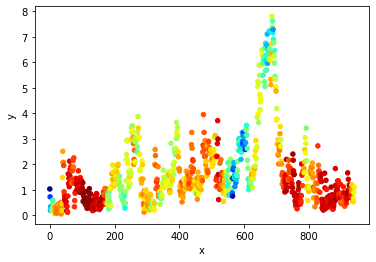

In [78]:
# * 探索代码
## Ensemble伪代码
'''
思路：设置软界限（soft boundary），upper bound q=0.98，lower bound \theta=0.90；threshold \epsilon，对应两个集合：异常集A、侯补集C
Define procedure detectAnomalies
Input: The prediction error of test dataset $e_{test}$，\epsilon，q，\theta
Begin:
Initialize $A = \phi$，$C = \phi$
Initialize \epsilon1 = quantile(X_{train}, q)
Initialize \epsilon2 = quantile(x_{train}, \theta)
for k > 0 do
  if e(k) > \epsilon1
    add to anomaly set A
  else if e(k) > \epsilon2
    add to candidate set C
    re estimate \epsilon1 and \epsilon2 using GPD quantile function
  else
    k = k + 1
  end if
end for
return A
'''
# 可视化交叉熵
df = pd.read_csv('jena_climate_2009_2016.csv')
series = df['wv (m/s)']
render_cross_entropy(series[0:1000])

# Code Repo

<AxesSubplot:>

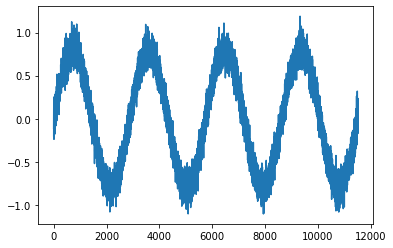

In [5]:
# 生成正弦波采样点
import numpy as np
x=np.linspace(0,8*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
pd.Series(y).plot.line()
# render_cross_entropy(pd.Series(y))

<AxesSubplot:>

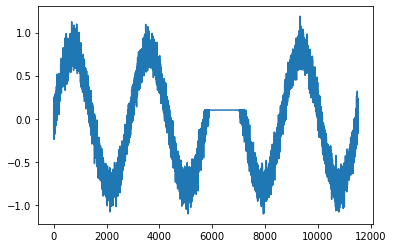

In [7]:
for i in range(5000, 8000):
    y[i] = min(0.1, y[i])
pd.Series(y).plot.line()

红移：排列熵越少，时序越规则；<br/>
蓝移：排列熵越大，时序越复杂

In [77]:
def render_cross_entropy(series, chunk_size=60, order=3):
    ## 计算交叉熵
    from pyentrp import entropy as ent
    perm_ent_series = []
    for i in range(0, series.count()-chunk_size):
        perm_ent_series.append(ent.permutation_entropy(series[i: i+chunk_size], order=order))
    ## 创建 color map
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    jet = plt.get_cmap('jet')
    min = pd.Series(perm_ent_series).min()
    max = pd.Series(perm_ent_series).max()
    len = pd.Series(perm_ent_series).count()
    cNorm  = colors.Normalize(vmin=min, vmax=max, clip=True)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    ## 映射 color map
    cols = []
    for i in range(0, len):
        cols.append(colors.rgb2hex(scalarMap.to_rgba(perm_ent_series[i])).upper())
    ## 可视化
    x = range(0, len)
    y = series[0:len]
    pd.DataFrame({'x': x, 'y': y}).plot.scatter(x='x', y='y', c=cols, colormap='jet')

In [ ]:
## 使用梯度提升树估计时间依赖性（证明：对特定问题，不需要深度回溯）
df = pd.read_csv('jena_climate_2009_2016.csv')
train = pd.DataFrame()
for i in range(0, 20):
    train['t-{}'.format(i)] = df['wv (m/s)'].shift(periods=i, fill_value=0)

X, y = train.iloc[:, 1:], train.iloc[:, 0]
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X, y)

xgb.plot_importance(xg_reg)